# Dataset 3 - Lung X-Ray Image Classification

 https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia


In [69]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Latex

from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier


## Exploring the Dataset

In [52]:
training_imgs_COV = len(os.listdir('C:/Users/Home/Data/train/COVID19'))
training_imgs_NORM = len(os.listdir('C:/Users/Home/Data/train/NORMAL'))
training_imgs_PNEU = len(os.listdir('C:/Users/Home/Data/train/PNEUMONIA'))
test_imgs_COV = len(os.listdir('C:/Users/Home/Data/test/COVID19'))
test_imgs_NORM = len(os.listdir('C:/Users/Home/Data/test/NORMAL'))
test_imgs_PNEU = len(os.listdir('C:/Users/Home/Data/test/PNEUMONIA'))
print(f"The training dataset has {training_imgs_COV} COVID19 lung images, {training_imgs_NORM} normal lung images, and {training_imgs_PNEU} pneumonia lung images.")
print(f"The test dataset has {test_imgs_COV} COVID19 lung images, {test_imgs_NORM} normal lung images, and {test_imgs_PNEU} pneumonia lung images.")

The training dataset has 460 COVID19 lung images, 1266 normal lung images, and 3418 pneumonia lung images.
The test dataset has 116 COVID19 lung images, 317 normal lung images, and 855 pneumonia lung images.


As shown above, the training dataset has 460 COVID19 lung images, 1266 normal lung images, and 3418 pneumonia lung images while the test dataset has 116 COVID19 lung images, 317 normal lung images, and 855 pneumonia lung images. This is 5144 training images and 1288 test images. This shows it is a fairly unbalanced dataset, with the majority of training and test images being pneumonia lung images.

The images are fairly high definition greyscale images, with many having resolution above 2000x2000px. 

## Preprocessing

In [2]:
Categories=['COVID19','NORMAL','PNEUMONIA'] 
flat_data=[] #input array
target=[] #output array
datadir='C:/Users/Home/Data/train' #path to training folder
#path which contains all the categories of images
for i in Categories:
    
    path=os.path.join(datadir,i) #appends i to datadir ex. ...Data/train/COVID19
    for img in os.listdir(path): 
        img_array=imread(os.path.join(path,img)) 
        img_resized=resize(img_array,(64,64,1)) #resizes arrays to 64x64 size
        flat_data.append(img_resized.flatten()) #takes resized array and flattens it
        target.append(Categories.index(i))
    print(f'loaded category:{i}') #to tell this is working and category finished
    
flat_data=np.array(flat_data) #turns flat_data into a numpy array
target=np.array(target) #creates target numpy array
df=pd.DataFrame(flat_data) #turns flat_data into a pandas dataframe
df['Target']=target #creates target output column on the dataframe
x_train=df.iloc[:,:-1] #input data in dataframe
y_train=df.iloc[:,-1] #output data in dataframe

loaded category:COVID19
loaded category:NORMAL
loaded category:PNEUMONIA


Above is the preprocessing for the training data. Theres two main preprocessing steps here. The first, in the for loop is turning all the images into much more managable 64x64 images. flattening them, and then putting them into the data list while the category of this image is stored in the target list. This then is done for every image in every category.

The second step, after the for loops is turning the data data array into numpy arrays, and then turning both of these into a pandas dataframe. Variables are then created to seperate the input data from output data for future use.

In [3]:
Categories=['COVID19','NORMAL','PNEUMONIA'] 
flat_data=[] #input array
target=[] #output array
datadir='C:/Users/Home/Data/test' #path to training folder
#path which contains all the categories of images
for i in Categories:
    
    path=os.path.join(datadir,i) #appends i to datadir ex: .../Data/test/COVID19
    for img in os.listdir(path): 
        img_array=imread(os.path.join(path,img)) 
        img_resized=resize(img_array,(64,64,1)) #resizes arrays to 80x80 size
        flat_data.append(img_resized.flatten()) #takes resized array and flattens it
        target.append(Categories.index(i))
    print(f'loaded category:{i}')
    
flat_data=np.array(flat_data) #turns flat_data into a numpy array
target=np.array(target) #creates target numpy array
df=pd.DataFrame(flat_data) #turns flat_data into a pandas dataframe
df['Target']=target #creates target output column on the dataframe
x_test=df.iloc[:,:-1] #input data in dataframe
y_test=df.iloc[:,-1] #output data in dataframe

loaded category:COVID19
loaded category:NORMAL
loaded category:PNEUMONIA


Above is the preprocessing for the test data. It is the same process as the training data, but I will go over again.

Theres two main preprocessing steps here. The first, in the foor loop is turning all the images into much more managable 64x64 images. flattening them, and then putting them into the data list while the category of this image is stored in the target list. This then is done for every image in every category.

The second step, after the for loops is turning the data data array into numpy arrays, and then turning both of these into a pandas dataframe. Variables are then created to seperate the input data from output data for future use.

## Processing

### Method 1 - SVM

In [4]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf']} #creates a parameter grid for C and Gamma
svc=svm.SVC(probability=True)  #creates SVC
model=GridSearchCV(svc,param_grid) #find best C and gamma values using cross-validation

Here is the first and most important part of the SVM method. First, a parameter grid is created using the hyperparameters of C and gamma, but first, what is C and gamma in this context?

C is the basically how soft the margin is, i.e. how many errors are allowed. Errors sound bad, but sometimes allowing some errors eliminates overfitting.

Gamma is roughly how curvy the boundary is. The closer to zero, the more straight the decision boundary, while a value of 1 makes it curve to capture every sample in its category. This is another case why a high value can cause overfitting issues.

The kernal for all this is RBF, a gaussian method used because linear and polynomial methods are usually bad fits for images. The parameter grid could be expanded to compare RBF to polynomial and linear methods, but this would cause very long processing time.

After the parameter grid is created, GridSearchCV is used to create the model. GridSearchCV basically creates a model for every value of C and gamma, and using 5-fold cross validation picks the best model.

In [5]:
model.fit(x_train, y_train) #fits model using inputs, outputs, and C and gamma values
model.best_params_  #outputs best C and gamma values

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

This is a very simple but important step, using sklearns .fit method, it fits the SVM model to the given inputs and outputs. Here, I also display the C and gamma being used for this model, which is C=10 and gamma=.001. This shows that the model is allowing some errors but has overall fairly straight boundaries.

In [6]:
y_pred=model.predict(x_test) #create predicted outputs for test data
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))


The predicted Data is :
[0 0 0 ... 1 2 2]
The actual data is:
[0 0 0 ... 2 2 2]


NameError: name 'accuracy_score' is not defined

Now sklearn's .predict method is used. This uses the model and only inputs, in this case the test images, to create predicted output categories.

In [43]:
print(f"The model has an accuracy score of {accuracy_score(y_pred,y_test)}")
print(f"The model has a precision score of {precision_score(y_pred,y_test, average='macro')}")
print(f"The model has a recall score of {recall_score(y_pred,y_test, average='macro')}")
print(f"The model has a f1 score of {f1_score(y_pred,y_test, average='macro')}")

The model has an accuracy score of 0.953416149068323
The model has a precision score of 0.9339063390252225
The model has a recall score of 0.957342718755164
The model has a f1 score of 0.9450912952732134


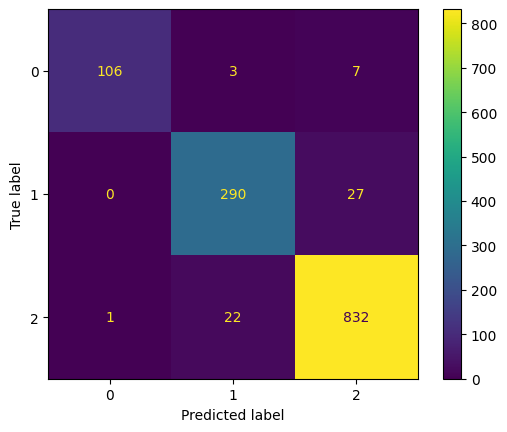

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp1.plot()
plt.show() # 0 = COVID19 | 1 = NORMAL | 2 = PNEUMONIA

Above are the stats for method one, including accuracy, recall, precision, f1, and a confusion matrix. The stats are found using the macro version average due to the imbalanced data set.

### Method 2 - K Nearest Neighbor

In [62]:
knn = KNeighborsClassifier()
k_range = list(range(1, 71))
param_grid = dict(n_neighbors=k_range)
knn_model = GridSearchCV(knn, param_grid, scoring='balanced_accuracy')

Above is the first step of the KNN method, first, knn is initialized as a KNN classifier. Then, a param grid is created ranging in values from 1 to 71 (71 being the square root of n). Like in the SVM method, GridSearchCV is then used to find the most accurate value of k using balanced accuracy because of the imbalanced dataset.

In [63]:
knn_model.fit(x_train,y_train) #fits data to the knn model using inputs and outputs of training data

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='balanced_accuracy')

Now that the model is found, the knn model is then trained using this value of k and the training inputs and outputs.

In [68]:
print(model.best_params_)

{'n_neighbors': 2}


This shows that the GridSearchCV found the most accurate value of k to be k=2.

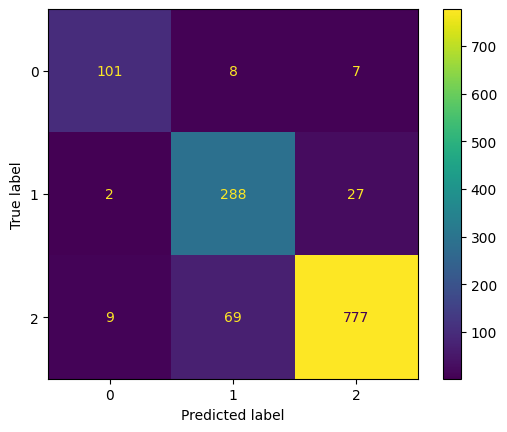

In [71]:
y_pred2 = knn_model.predict(x_test)
cm2 = confusion_matrix(y_test, y_pred2, labels=model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model.classes_)
disp2.plot()
plt.show() # 0 = COVID19 | 1 = NORMAL | 2 = PNEUMONIA

In [72]:
print(f"The second model has an accuracy score of {accuracy_score(y_pred2,y_test)}")
print(f"The second model has a precision score of {precision_score(y_pred2,y_test, average='macro')}")
print(f"The second model has a recall score of {recall_score(y_pred2,y_test, average='macro')}")
print(f"The second model has a f1 score of {f1_score(y_pred2,y_test, average='macro')}")

The second model has an accuracy score of 0.90527950310559
The second model has a precision score of 0.8959929783849013
The second model has a recall score of 0.8829677530015774
The second model has a f1 score of 0.8877709338610168


Above are the stats for method two, including accuracy, recall, precision, f1, and a confusion matrix. The stats are found using the macro version average due to the imbalanced data set.

## Comparative Analysis

### Complexity

When comparing complexity, method two wins out by far. Method Two (KNN) took a few minutes to run through the Grid Search and create the model. In comparison, while I do not have the exact time it took because I ran it while I slept and my time tracking method broke, Method One (SVM) took at least a couple hours. Which is amazing considering KNN had to run 71 possible k values.

### Performance

SVM Method


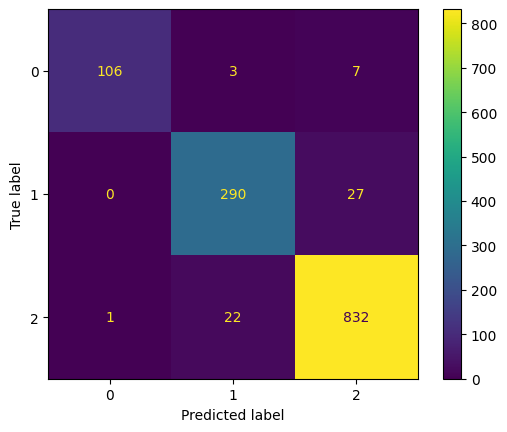

KNN Method


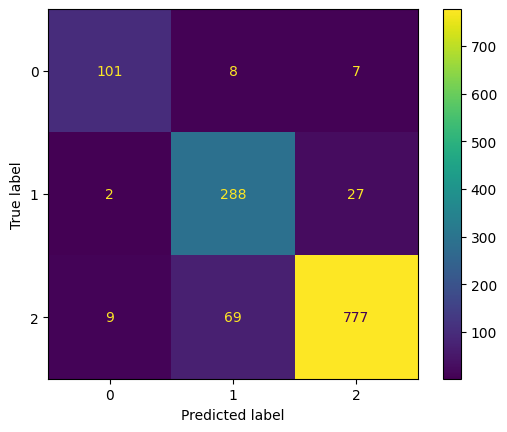

The SVM model has an accuracy score of 0.953416149068323
The SVM model has a precision score of 0.9339063390252225
The SVM model has a recall score of 0.957342718755164
The SVM model has a f1 score of 0.9450912952732134 

The KNN model has an accuracy score of 0.90527950310559
The KNN model has a precision score of 0.8959929783849013
The KNN model has a recall score of 0.8829677530015774
The KNN model has a f1 score of 0.8877709338610168


In [78]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp1.plot()
print("SVM Method")
plt.show() # 0 = COVID19 | 1 = NORMAL | 2 = PNEUMONIA

y_pred2 = knn_model.predict(x_test)
cm2 = confusion_matrix(y_test, y_pred2, labels=model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model.classes_)
disp2.plot()
print("KNN Method")
plt.show() # 0 = COVID19 | 1 = NORMAL | 2 = PNEUMONIA

print(f"The SVM model has an accuracy score of {accuracy_score(y_pred,y_test)}")
print(f"The SVM model has a precision score of {precision_score(y_pred,y_test, average='macro')}")
print(f"The SVM model has a recall score of {recall_score(y_pred,y_test, average='macro')}")
print(f"The SVM model has a f1 score of {f1_score(y_pred,y_test, average='macro')} \n")

print(f"The KNN model has an accuracy score of {accuracy_score(y_pred2,y_test)}")
print(f"The KNN model has a precision score of {precision_score(y_pred2,y_test, average='macro')}")
print(f"The KNN model has a recall score of {recall_score(y_pred2,y_test, average='macro')}")
print(f"The KNN model has a f1 score of {f1_score(y_pred2,y_test, average='macro')}")

Above we can see the confusion matrices for method one and two respectively, and their resulting metrics. Looking at both, it is obvious that Method 1 has better performance, with higher scores in every metric. 

### Final Recommendation
My recommendation of what method should go into production is method 1. This is because although it is more complex and computationally intensive, performance is especially important in the medical field, and computers can be used that are much better than my 10 year old one


## Ethical Issues
This dataset has the most ethical intensive discussion necessary. Misdiagnose can potentially be deadly in the medical field, and if put in use it is possible for it to indirectly kill someone. This is why it would be important to further refine this model, and also compare it how doctors perform at diagnosing. If doctors are able to diagnose much more accurately and precise, and is pointless and danger to use a machine learning model instead.

## Bibliography

Kumar, A. M. (2018, December 17). C and gamma in SVM. Medium. Retrieved December 18, 2022, from https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be 

Leung, K. (2022, September 13). Micro, Macro &amp; weighted averages of F1 score, clearly explained. Medium. Retrieved December 18, 2022, from https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f 

Myrianthous, G. (2021, March 14). Fit() vs predict() vs fit_predict() in python scikit-learn. Medium. Retrieved December 18, 2022, from https://towardsdatascience.com/fit-vs-predict-vs-fit-predict-in-python-scikit-learn-f15a34a8d39f 

Sklearn.metrics.confusion_matrix. scikit. (n.d.). Retrieved December 18, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html 

Sklearn.neighbors.kneighborsclassifier. scikit. (n.d.). Retrieved December 19, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

Yıldırım, S. (2020, June 1). Hyperparameter tuning for support vector machines - C and gamma parameters. Medium. Retrieved December 18, 2022, from https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167 